In [1]:
import numpy as np
import scipy.io as scio    
import os,re
from scipy import ndimage
from matplotlib import pyplot as plt

In [2]:
import keras

Using Theano backend.


In [3]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Concatenate
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,CSVLogger
from keras import backend as keras

In [4]:
images = np.load('total_images.npy')
gt_labels = np.load('gt_labels_binary.npy')

In [5]:
print(len(images))
print(len(gt_labels))

2000
2000


In [6]:
train_indices = np.random.choice(2000,1900,replace=False)
print(len(train_indices))

1900


In [7]:
train_images = [images[i] for i in train_indices]
train_labels = [gt_labels[i] for i in train_indices]

In [8]:
print(len(train_images))
print(len(train_labels))

1900
1900


In [9]:
test_indices = [i for i in range(2000) if i not in train_indices]
print(len(test_indices))

100


In [10]:
test_images = [images[i] for i in test_indices]
test_labels = [gt_labels[i] for i in test_indices]

In [11]:
print(len(test_images))
print(len(test_labels))

100
100


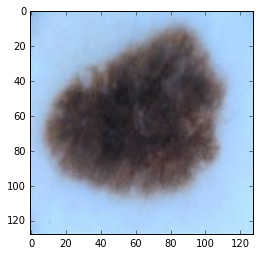

In [12]:
plt.imshow(images[0])
plt.show()

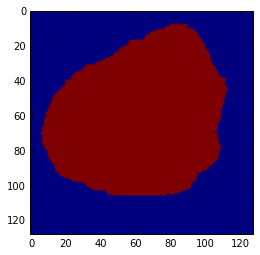

In [13]:
plt.imshow(gt_labels[0])
plt.show()

In [14]:
print(gt_labels.shape)

(2000, 128, 128)


In [15]:
image_dims = images[0].shape
print(image_dims)

(128, 128, 3)


In [16]:
train_mean = np.mean(train_images,axis = (0,1,2,3))
train_std = np.std(train_images,axis = (0,1,2,3))
train_images = (train_images - train_mean)/(train_std+1e-7)

In [17]:
test_mean = np.mean(test_images,axis=(0,1,2,3))
test_std = np.std(test_images,axis = (0,1,2,3))
test_images = (test_images-test_mean)/(test_std+1e-7)

In [18]:
train_labels = np.expand_dims(train_labels,axis=3)
test_labels = np.expand_dims(test_labels,axis=3)

In [19]:
print(train_labels.shape)
print(test_labels.shape)

(1900, 128, 128, 1)
(100, 128, 128, 1)


In [20]:
np.save('train_images.npy',train_images)
np.save('test_images.npy',test_images)
np.save('train_labels.npy',train_labels)
np.save('test_labels.npy',test_labels)

In [21]:
train_images = np.load('train_images.npy')
test_images = np.load('test_images.npy')
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

In [22]:
def get_unet_model(image_dims):
    inputs = Input((image_dims[0],image_dims[1],image_dims[2]))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=3)([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [23]:
model = get_unet_model(image_dims)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [24]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Unet_lr_e4_bs_10.csv')
model_checkpoint = ModelCheckpoint("Unet_lr_e4_bs_10.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [26]:
model.fit(train_images, train_labels, batch_size=10, epochs=200, verbose=1,validation_data=(test_images,test_labels), shuffle=True, callbacks=[lr_reducer,csv_logger,model_checkpoint])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1900 samples, validate on 100 samples
Epoch 1/200
 172/1900 [=>............................] - ETA: 1:59:51 - loss: 0.6954 - acc: 0.6866

KeyboardInterrupt: 

In [ ]:
results = model.predict(test_images[0])